In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import find_peaks
import sys 
import random
import scipy as sp
from scipy import optimize
from scipy.optimize import least_squares
from scipy.special import erf
from time import time
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from os.path import join, exists
from platform import uname
from datetime import datetime
import matplotlib.patheffects as pe
from configparser import ConfigParser

In [2]:
def Weighted_Independent_Blocks(x, w, block_dim, verbose = False):

    #  returns a reshaped version of a random variable x with its weights w
    #  by considering as independent not all the elements of x, but blocks of a dimension dim (decided a priori)

    dim = len(x)
    n_block = int(dim/block_dim)

    if n_block == 0: n_block = 1

    X = np.zeros(n_block)
    W = np.zeros(n_block)

    for ii in range(n_block):

        i0 = ii*block_dim
        i1 = (ii+1)*block_dim

        if i1> dim: 
            X[ii] = np.average(x[i0:], weights=w[i0:])
            W[ii] = np.sum(w[i0:])
            break

        else:
            #print(i0, i1)
            #print(x[i0:i1], w[i0:i1])
            X[ii] = np.average(x[i0:i1], weights=w[i0:i1])
            W[ii] = np.sum(w[i0:i1])

    if verbose: print('Completed.\nInitial dimension = {}\nBlock dimension = {}\nn_block = {}'.format(dim, block_dim, n_block))

    return X, W

def Get_Sigma_from_Bootstrapping(X, W, n_boot, n_block, ):

    """
    Returns the std deviation by bootstrapping analysis for the population X with weights W 
    (OSS: in our case for now X, W come out from block analysis performed with Weighted_Independent_Blocks() )
    """

    ave_boot = np.zeros(n_boot)
    for ii_boot in range(n_boot):
        blocks = random.choices(range(n_block), k = n_block)
        ave_boot[ii_boot] = np.average(X[blocks], weights=W[blocks])

    # return the sigma
    return np.std(ave_boot)



def Weighted_Sigma_of_Mean(x, w,):

    # return the best estimator of the variance of the mean of a random variable x with weights w

    return np.sqrt((np.sum(w**2 * (x - np.average(x, weights = w))**2))/(np.sum(w)**2))

In [3]:
#Lib_Reweighting.py functions

def read_cs_md(data):

 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[] 
        timeseries=np.asarray(riga[2:-1]).astype(float)
        confd[key2][key]=timeseries
 return(confd)

def read_exp_cs(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
          
 for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[]
        confd[key2][key] += map(float, [float(riga[2])])
 return(confd)

def add_md_data(data,dict,key,):
  dict[key]={}
  for lines in open(data, "r").readlines():

        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        key2=riga[0]
        timeseries=np.asarray(riga[1:-1]).astype(float)
        dict[key][key2]=[]
        dict[key][key2]=(timeseries)
  return(dict)

def add_exp_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        key2=riga[0]
        dict[key][key2]=[]
        dict[key][key2] += map(float, [float(riga[1])])
  return(dict)

def add_md_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[0:-1]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[1:]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)

#def scale_rdc_Q(exp,calc):
  
#     def residuals(p,y,x):
#         c = p
#         err = ((c*y)-x)
#         return err
#     p0=0.0001
#     exp  = np.trim_zeros(exp)
#     calc = np.trim_zeros(calc)
        
#     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
#     rmsd_i=(sum(np.square((exp-calc)))/(len(exp)))**0.5
#    
#     c,d=sp.optimize.leastsq(residuals,p0,args=(calc,exp))
#     fit=c*calc
#     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
#     rmsd_f=(sum(np.square((exp-fit)))/(len(exp)))**0.5
#     return Q_i,rmsd_i,Q_f,rmsd_f,fit,c

def scale_rdc_Q_fit(exp,calc):
     def residuals(p,y,x):
         c = p
         err = ((c*y)-x)
         return err
     p0=0.0001
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c,d=leastsq(residuals,p0,args=(calc,exp))
     fit=c*calc
     #print("Calc:",calc,"Fit:",fit)
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit
    

def scale_rdc_Q(exp,calc):
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c=np.linalg.norm(np.dot(exp,calc))/(np.dot(calc,calc))
     fit=c*calc
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit,c

In [4]:
def Separate_Validation_Reweighting_Data(CS, true_exp_labels):
  
    if ((type(CS) == list) & (len(CS) >= 2)):

        Reweight_Data = []#true_exp_labels.copy()
        for cs in CS:
            Reweight_Data.append(cs)

        Validation_Data = true_exp_labels.copy()
        for cs in CS:
            Validation_Data.remove(cs)
        
        # create a label string for more-than-one reweighting data
        string = CS[0]
        for cs in CS[1:]:
            string += '-{}'.format(cs)

        CS = string


    else:
        
        if type(CS) == list:
            CS = CS[0]

        Validation_Data = true_exp_labels.copy()
        Validation_Data.remove(CS)

        Reweight_Data = [CS]

        CS = str(CS)
    
    return CS, Reweight_Data, Validation_Data


def Align_Comp_Exp_Data(compdata, expdata):

  for data1, data1_t in zip([compdata, expdata], ['comp', 'exp'] ):
    data2 = expdata if data1_t == 'comp' else compdata
    to_align = {}
    for key1 in data1.keys():
      to_align[key1] = []
      for key2 in data1[key1].keys():
        if ((key2 not in data2[key1].keys())|(data1[key1][key2][0] == 0.)):
          to_align[key1].append(key2)

    for key1 in to_align.keys():
      for key2 in to_align[key1]:
        if key2 in data1[key1].keys():
          data1[key1].pop(key2)
        if key2 in data2[key1].keys():
          data2[key1].pop(key2)
          
  return compdata, expdata

def Get_Right_Color(keys, colors):

  cols = []
  for key in keys: 
    cols.append(colors[key])
  return cols


def Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type):

    print('# of Frames:',nframes)

    print('Reweight Data Points:',nobs_r)
    for key in data_r_type:
        print(str(key)+':',sum(data_r_type[key]))

    print('Validation Data Points:',nobs_v)
    for key in data_v_type:
        print(str(key)+':',sum(data_v_type[key]))
        
def Process_Data_Into_Arrays(data, expdata, compdata, err_d, compare_dict):

    ### OBS: this process takes into account that for the chemical shift we DO NOT HAVE experimental data on border residues --> the data_type boolean mask count zero for those residues even if MD provide such data

    ### data represent either Reweight_Data either Validation_Data
    ### same operationas

    exp=[] 
    traj=[]
    err=[]
    data_t=[]
    data_type={}

    #Process Reweight data into arrays
    for key in data:   
        for key2 in expdata[key]:
        #print(key,key2,expdata[key][key2][0])
        #Check if Experimental Value is 0, if not retrieve the MD timeseries 
            if expdata[key][key2][0]!=0:  
                if key2 in compdata[key]:
                    if compdata[key][key2][0]!=0:
                        compare_dict[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
                        traj.append(compdata[key][key2])
                        exp.append(expdata[key][key2][0])
                        err.append(err_d[key]) 
                        data_t.append(str(key))

    for key in data: 
        data_id=np.zeros(len(data_t)) 
        for i, id in enumerate(data_t): 
            if id==str(key):
                data_id[i]=float(1)
        data_type[key]=data_id 

    return np.asarray(exp), np.asarray(traj), np.asarray(err), data_t, data_type, compare_dict


def Process_Data_Into_Arrays_with_sigma(data, expdata, compdata, err_d, sigma_dict, compare_dict):

    ### OBS: this process takes into account that for the chemical shift we DO NOT HAVE experimental data on border residues --> the data_type boolean mask count zero for those residues even if MD provide such data

    ### data represent either Reweight_Data either Validation_Data
    ### same operationas

    exp=[] 
    traj=[]
    err=[]
    data_t=[]
    sigmas = []
    data_type={}

    #Process Reweight data into arrays
    for key in data:   
        for key2 in expdata[key]:
        #print(key,key2,expdata[key][key2][0])
        #Check if Experimental Value is 0, if not retrieve the MD timeseries 
            if expdata[key][key2][0]!=0:  
                if key2 in compdata[key]:
                    if compdata[key][key2][0]!=0:
                        compare_dict[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
                        traj.append(compdata[key][key2])
                        exp.append(expdata[key][key2][0])
                        sigmas.append(sigma_dict[key][key2][-1])
                        err.append(err_d[key]) 
                        data_t.append(str(key))

    for key in data: 
        data_id=np.zeros(len(data_t)) 
        for i, id in enumerate(data_t): 
            if id==str(key):
                data_id[i]=float(1)
        data_type[key]=data_id 

    return np.asarray(exp), np.asarray(traj), np.asarray(err), np.asarray(sigmas), data_t, data_type, compare_dict

def Normalize_Weights(weights, ):

  ## OBS the argument is not really a weight, is the log...

  weights -= np.max(weights)
  weights =  np.exp(weights)
  weights /= np.sum(weights)  

  return weights

def Print_RMSE(data_type, obs, obs_exp,):

  print(" * Total :     %6.3lf" % np.sqrt(np.mean((obs-obs_exp)**2)))

  for t in data_type:

      print(" *    %2s :" % t, end = '')
      print("     %6.3lf" % np.sqrt(np.sum((obs-obs_exp)**2*data_type[t])/np.sum(data_type[t])))
      if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale=scale_rdc_Q(obs*data_type['RDC'],obs_exp*data_type['RDC'])
        #print(" *    RDC scaled RMSD:", end = '')
        #print(" %6.3lf" % rms_f)
        print(" *    RDC scaled Q:", end = '')
        print(" %6.3lf" % qf)

  if 'RDC' in data_type:  
    return qi, rms_i, qf, rms_f, rdc_scale
  else: return [None]*5

def RMSE(theor, exp):
  if len(theor) != len(exp): raise ValueError('Incopatible lenght between theor ({}) and exp ({})'.format(len(theor), len(exp)))

  theor = np.array(theor)
  exp = np.array(exp)
  return np.sqrt(np.sum(((theor-exp)**2)/(len(exp))))

def Calculate_RMSE(data_type, obs, obs_exp,):

  RMSEs = {}

  RMSEs['Tot'] = RMSE(obs, obs_exp)
  for t in data_type.keys():
    RMSEs[t] = RMSE(np.trim_zeros(data_type[t]*obs), np.trim_zeros(data_type[t]*obs_exp))
  
  return RMSEs

def Energy_Score_MML(MD, sigma_MD, exp, sigma_fwd = None):

  # Returns the Marginalizex Maximum Likelihood Energy Score
  # (ask Max for Bayesian details)


  MD = np.array(MD, dtype= float)
  exp = np.array(exp, dtype= float)
  sigma_MD = np.array(sigma_MD, dtype= float)

  delta = (MD - exp)

  if sigma_fwd: 
    sigma_fwd = np.array(sigma_fwd, dtype=float)
    sigma = np.sqrt(sigma_MD**2 + sigma_fwd**2)
  else: sigma = sigma_MD

  if len(MD) != len(exp): raise ValueError('Incopatible lenght between theor ({}) and exp ({})'.format(len(MD), len(exp)))

  errf = erf((2.**-.5)*(delta/sigma))

  # K_blotzmann = 1
  return -np.sum(np.log(.5*errf/delta))


def Energy_Score(MD, sigma_MD, sigma_fwd, exp, sigma_prior = 'Jeffreys', compatibility = False):

  # sigma_MD = statistical error from sampling
  # sigma_fwd = average error of forward model

  # OBS: it works with residue exp data: male the sum over residues for a given type of data
  # together with the energy score it returns the "compatibility" i.e.
  # within the exp data exp the number of MD data that are compatible in one sigma_MD

  MD = np.array(MD, dtype= float)
  exp = np.array(exp, dtype= float)
  sigma_MD = np.array(sigma_MD, dtype= float)
  sigma_fwd = np.array(sigma_fwd, dtype=float)

  if len(MD) != len(exp): raise ValueError('Incopatible lenght between theor ({}) and exp ({})'.format(len(MD), len(exp)))

  sigma = (sigma_MD**2+sigma_fwd**2)**0.5

  delta = ((MD-exp)/sigma)**2

  if compatibility: is_compatible = [True if d <= 1 else False for d in delta]

  if sigma_prior == 'sigma_std_prior':
    if compatibility: return np.sum(is_compatible), np.sum(np.log(sigma)+(0.5*delta))
    else: return np.sum(np.log(sigma)+(0.5*delta))
  elif sigma_prior == 'Jeffreys':
    if compatibility: return np.sum(is_compatible), np.sum(2*np.log(sigma)+(0.5*delta))
    else: return np.sum(2*np.log(sigma)+(0.5*delta))

  else: raise ValueError('Sigma mode chosen not properly: {}'.format(sigma_prior))

def Calculate_Energy_Score(data_type, MD, sigma_MD, sigma_fwd, exp, sigma_prior = 'Jeffreys', compatibility = False):

  ### OBS: it is not possible to have the same treatment of the obs variables and sigma variables, because I am calculating sigma after the
  #        reweighting process
  ### ---> the trim_zeros operation is not needed for sigma

  if compatibility:
    Scores = {}
    Is_Compatibles = {}
    Is_Compatibles['Tot'], Scores['Tot'] = Energy_Score(MD, sigma_MD, sigma_fwd, exp, sigma_prior=sigma_prior, compatibility=compatibility)
  else:
    Scores = {}
    Scores['Tot'] = Energy_Score(MD, sigma_MD, sigma_fwd, exp, sigma_prior=sigma_prior,)

  for t in data_type.keys():

    if compatibility:
      Is_Compatibles[t], Scores[t] = Energy_Score(np.trim_zeros(data_type[t]*MD), np.trim_zeros(data_type[t]*sigma_MD), np.trim_zeros(data_type[t]*sigma_fwd), np.trim_zeros(data_type[t]*exp), sigma_prior= sigma_prior, compatibility=compatibility)
    else: 
      Scores[t] = Energy_Score(np.trim_zeros(data_type[t]*MD), np.trim_zeros(data_type[t]*sigma_MD), np.trim_zeros(data_type[t]*sigma_fwd), np.trim_zeros(data_type[t]*exp), sigma_prior= sigma_prior,)

  if compatibility:  return Is_Compatibles, Scores
  else: return Scores  


def Get_Sigma_from_Independent_Blocks(traj, weights, key, start, stop, step, idx_check = 3, min_dim = 1000, bootstrap = False, n_boot = None, verbose = None, fig = False, spec_res = False):

  # "wrapper" for the function Weighted_Independent_Block to be utilized for all data of reweighting project
  # It works with dict-organized trajectory data: the keys are residue number, their value is the quantity over simulation

  nres = len(traj)
  nframes = len(traj[list(traj.keys())[0]])

  if verbose >= 1: 
    print('\n******************\nAnalyzing statistical errors for {} data\nNframes = {}\tNdata(res) = {}'.format(key, nframes, nres))

  ### ITERATION OVER BLOCK DIMENSION
  
  tot_start = time()

  block_dim = np.arange(start, stop+1, step) 

  df_block = pd.DataFrame(columns = ('Saturation_Value', 'Block_Dim', 'Last_Derivative',  'Fit_Success', 'Elapsed_Time'), index = traj.keys())

  if verbose >= 2:
    print('Beginning block analysis')

  for key2 in traj.keys():

    # to perform only on one residue
    if ((spec_res != False )&(key2 != spec_res)):
      if verbose >= 1: print('Skippato {}: spec_res = {}'.format(key2, spec_res))
      pass
      
    else:

      averages = []
      sigmas = []

      a = traj[key2]
      w = weights
      
      if verbose >= 2: 
          print('\n{} Data\tResidue {}'.format(key, key2))
          print('N frames = {}\nWeighted average: {}\nInitial weighted std variation: {}'.format(nframes, np.average(a, weights=weights), Weighted_Sigma_of_Mean(a, w)))

      start_block = time()

      for dim, ll in zip(block_dim, range(len(block_dim))):

        n_block = int(nframes/dim)

        A, W = Weighted_Independent_Blocks(a, w, dim, verbose= False)
        ave = np.average(A, weights=W)
        sigma = Weighted_Sigma_of_Mean(A, W) if not bootstrap else Get_Sigma_from_Bootstrapping(A, W, n_boot, n_block )

        # saturation check
        if ((ll>idx_check) & (dim>min_dim) ):
          if (sigma <= sigmas[idx_check]):
              stopped = True
              if verbose >= 3:
                print('We are in noise regime: I stop block analysis for {}'.format(key+key2))
              break
        else: stopped = False

        averages.append(ave)
        sigmas.append(sigma)

      # end of block analysis
      stop_idx = ll if stopped else ll-1
      end_block = time()
      block_time = end_block-start_block

      if verbose >= 1:
        print('Elapsed time for {}{} block analysis: {:3.2f} s'.format(key, key2, block_time))    

      ########### FIT and estimation of saturation values

      #print(Saturation_Residuals(p0,block_dim[:stop_idx], sigmas[:stop_idx] ))

      try:
        p0 = [-.1, .01, .1, .1]
        fit = least_squares(Saturation_Residuals, x0 = p0, args= [block_dim[:stop_idx], sigmas[:stop_idx]], bounds = ((-np.inf, -np.inf, 0, 0,), (np.inf, np.inf, np.inf, np.inf)), verbose = verbose-1 if verbose != 0 else verbose)
        success = fit.success
        x = block_dim[:stop_idx]
        y = saturation_func(x, fit.x)
        sat_dim = x[-1]
        last_ddx = saturation_derivative(x[-1], fit.x)

        first_value = y[0]
        sat_value = y[-1]
        
        if fig: 
          
          f, ax = plt.subplots()
          ax.hlines(sat_value, x[0], x[-1], ls = 'dotted', color = 'grey', label = 'sat value')
          ax.plot(x, y, c = 'firebrick', ls = 'dashed', alpha = 0.6, label = 'fit')
          ax.plot(block_dim[:stop_idx], np.array(sigmas[:stop_idx]), marker = 'o', ms = 2.6, markerfacecolor = 'k', ls = 'dashed', color = 'goldenrod', label = '{}: res {}'.format(key, key2))
          ax.set_title('Block analysis for MD statistical error', fontweight = 'bold')
          ax.set_xlabel('Dimension of blocks')
          ax.set_ylabel('Sigma of average')
          ax.legend(loc = 'lower right')
          plt.show(block=False)
          plt.pause(0.0003)
          plt.close()
          

      except ValueError:
        
        print('Skipped fit')
        sat_value = max(sigmas[:stop_idx])
        sat_dim   = dim
        last_ddx  = np.nan
        first_value = sigmas[0]
        success   = False

      df_block.at[key2, 'Average']          = np.average(A, weights=W)
      df_block.at[key2, 'Saturation_Value'] = sat_value
      df_block.at[key2, 'Block_Dim']      = sat_dim
      df_block.at[key2, 'Fit_Success']    = success
      df_block.at[key2, 'Elapsed_Time']   = block_time
      df_block.at[key2, 'Last_Derivative'] = last_ddx
      df_block.at[key2, 'First_Value']     = first_value

  # FINAL PERFORMANCES
  tot_end = time()
  if verbose >= 1:
    print('\n\nElapsed time for all the analysis: {:3.2f} s'.format(tot_end-tot_start))
    print('Converged fit: {}/{}'.format(np.sum(df_block.Fit_Success.values), len(df_block)))

  if df_block.shape[0] != nres: 
    raise ValueError('Porcamadonna: {} ha cambiato le cose'.format(key))
  return df_block


###########################################################################################
#### REWEIGHTING PROCEDURE - MAXENT CALCULATIONS

# function to be minimized to obtain lagrangian multipliers l

###########################################################################################
####BLOCK ANALYSIS

def saturation_func(x, p):

  return (p[0]/(x+p[1])**p[2])+p[3]

def saturation_derivative(x, p):

  return -p[0]*p[2]*(x + p[1])**-(p[2]+1)

def Saturation_Residuals(p, x, y):

  return saturation_func(x, p)-y 

def Print_Separator(char = '#', how_many = 70, file=sys.stdout):
    print('\n\n{}\n'.format('{}'.format(char)*int(how_many)), file = file)

In [5]:
def Fix_Excel_Format(df):
  if type(df) == pd.DataFrame:
      
    for row in df.index:
      if row != 'Tot':
          for col in df.columns:
              if ((type(df.at[row, col]) != dict) & (df.at[row, col] != np.nan)):
                  df.at[row,  col] = eval(df.at[row,  col], {'nan': np.nan})

  if type(df) == pd.Series:
      
    for row in df.index:
      if row != 'Tot':
              if ((type(df.at[row]) != dict) & (df.at[row] != np.nan)):
                  df.at[row] = eval(df.at[row], {'nan': np.nan})              
  
  
  return df

In [6]:
outdir = '/Users/kaushikborthakur1211/Desktop/scripts/PaaA2/Charmm36m/'
datadir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/Charmm36m/Average_Data/'
expdatadir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/Exp_Data/'

if not os.path.exists(outdir):
    os.makedirs(outdir)

print("outdir",outdir)
print("datadir",datadir)
print("expdata_dir",expdatadir)

outdir /Users/kaushikborthakur1211/Desktop/scripts/PaaA2/Charmm36m/
datadir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/Charmm36m/Average_Data/
expdata_dir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/PaaA2/Exp_Data/


In [7]:
chemical_shifts =['CB', 'HA', 'CA', 'H', 'N']
colors = {'HA': 'orange', 'CA': 'red',  'CB': 'forestgreen', 'H': 'mediumorchid', 'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'Tot': 'black'}

thetas=[1,5,10,20]
theta_0 = { 'HA': 1., 'CA': 1, 'CB': 1., 'C':  1., 'H':  1.,'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1., 'JHNHA': 1.}
theta_break     = False
rew_break       = False
save            = True
to_remove       = ['HA2', 'HA3']
reweighting_keys = ['CA', 'CB','HA','H','N','SAXS','RDC']
blk_start = 2
blk_stop = 500
blk_step = 100
#blk_start = 10
#blk_stop = 200
#blk_step = 100
blk_verbose = 0
bootstrap = False
n_boot = 500
saturation_fig = False

#[Calculations]
do_RMSE = True
do_Energy_Score = True
compatibility = False
# choose between 1 for block analysis, 2 block analysis 2.0
statistical_error = 1
sigma_fwd = False
save = True


#thetas = Get_Theta_from_ini(config)
print(thetas)
thetas_str =  ['{:.2f}'.format(t) for t in thetas]
#Select Reference Theta
ref_theta=thetas_str[-1]

print('Main settings:\n')
print('Thetas = {}'.format(thetas_str))
print('Reference theta for statistical errors: {}'.format(ref_theta))
print('Reweighting keys: {}'.format(reweighting_keys))
print('Break reweight cycle = {}'.format(rew_break))
print('Break theta cycle = {}'.format(theta_break))
print('Block analysis: start = {}, stop = {}, step = {}, bootstrap = {}'.format(blk_start, blk_stop, blk_step, bootstrap))
print('Save: {}'.format(save))

name="gen_data"
if name:
  save_path = join(outdir, name)

[1, 5, 10, 20]
Main settings:

Thetas = ['1.00', '5.00', '10.00', '20.00']
Reference theta for statistical errors: 20.00
Reweighting keys: ['CA', 'CB', 'HA', 'H', 'N', 'SAXS', 'RDC']
Break reweight cycle = False
Break theta cycle = False
Block analysis: start = 2, stop = 500, step = 100, bootstrap = False
Save: True


In [8]:
##########################  ACQUIRE COMPUTATIONAL AND EXPERIMENTAL DATA

# chemical shifts
expdata=read_exp_cs(join(expdatadir,'CS.exp.dat'))
compdata=read_cs_md(join(datadir,'chemical_shifts.all.csv'),)
# RDC
expdata=add_exp_data(join(expdatadir,'RDC.exp.dat'),expdata,'RDC')
compdata=add_md_data(join(datadir,'RDC.all.csv'),compdata,'RDC')

# Gyration radium
expdata=add_exp_scalar(2.24,expdata,'Rg')
compdata=add_md_scalar_skip0(join(datadir,'Rgyr-CA.all.csv'),compdata,'Rg')

#SAXS
expdata=add_exp_data(expdatadir+'/SAXS.exp.dat',expdata,'SAXS')
compdata=add_md_data(datadir+'/SAXS.csv',compdata,'SAXS')

# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)

####### TRAJ-related quantities

nframes = len(compdata[list(compdata.keys())[0]][list(compdata[list(compdata.keys())[0]].keys())[0]])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove ]


print('Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format([str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'RDC', 'Rg', 'SAXS']
Number of frames = 29976


In [9]:
def func(l, traj_r, obs_exp_r, weight_bias, sigma,sigma_md ):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    f += 0.5*np.sum((sigma)*l**2+sigma_md*sigma_md*l**2)
    der += (sigma)*l+sigma_md*sigma_md*l
    #der += (sigma)*l
    return(f,der)

In [10]:
theta_0 = { 'HA': 1., 'CA': 1, 'CB': 1., 'C':  1., 'H':  1.,'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1., 'JHNHA': 1., 'SAXS' : 1.}


#Kish Ratio Scan

To_Scan=reweighting_keys
#reweighting_keys = ['CA', 'CB','JHNHA']

#Thetas = ['1.00','2.00','5.00', '10.00', '20.00','40.00','60.00','100']

#thetas=[0,0.5,1,1.5,2,2.53,4,5,10,20,30]
thetas=np.linspace(0,200,100)
ref_theta=thetas[-1]

KishScan={}
RMSE_dict={}
Sigma_dict={}

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan[CS]={}
    output_dir=join(save_path, CS)        
    print('Reweight Data = {}'.format(CS))
    RMSE_dict[CS]={}
    print('Validation Data = {}'.format(Validation_Data))


    ### debugging variables
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure


    # i) Process Reweight data into arrays "à la Paul"
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data, expdata, compdata, theta_0, compare_dict_r)

    # ii) Process Validation data into arrays "à la Paul"
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data, expdata, compdata, theta_0, compare_dict_v)
    # THETA CYCLE
    theta_list=[]
    kish_list=[]
    rmsd_f_list=[]
    for theta_m in np.flip(thetas):
      s = '{:.2f}'.format(theta_m)
      RMSE_dict[CS][s]={}

      # iii) Managing errors
      theta=theta_m*err_r
      
      # iv) Print dimensions
      nobs_r = len(obs_exp_r)
      nobs_v = len(obs_exp_v)
      #Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

      # v) perform minimization
      # OBS: res.X = lagrange multiplier
      weight_bias=np.ones(nframes)
      #print(np.shape(theta),np.shape(err_r))
      #print(theta,err_r)
      #Determine optimally scaling for calculated RDCs
    
      if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


      if 'RDC' in Validation_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_v=np.dot(traj_v,initial_weights)
       exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_v_type['RDC']==1)
       traj_v[RDC_rows]=traj_v[RDC_rows]*c

      res = sp.optimize.minimize(func, args = (traj_r, obs_exp_r, weight_bias,theta,err_r), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
      initial_weights = Normalize_Weights(weight_bias)
      initial_obs_r=np.dot(traj_r,initial_weights)
      initial_obs_v=np.dot(traj_v,initial_weights)
      #if res.success: print("\nMinimization worked: {}\n".format(res.success))
      #else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
      final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      # e) final average observables for reweighting and validation
      final_obs_r=np.dot(traj_r,final_weights)
      final_obs_v=np.dot(traj_v,final_weights)
      # g) calculating Kish effective size
      Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
      Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
      #print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
      #print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
      Kish_ratio = (Ks_a/Ks_b)*100
      RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
      #print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
      theta_list.append(theta_m)
      kish_list.append(Kish_ratio)  
      rmsd_f_list.append(RMSE_reweight)
      RMSE_r_i={}
      RMSE_v_i={}
      RMSE_r_f={}
      RMSE_v_f={}
      RMSE_r_i['Tot']=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      for t in data_r_type:
       RMSE_r_i[t]=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_i['RDC_Q']=qf

      RMSE_v_i['Tot']=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
      for t in data_v_type:
       RMSE_v_i[t]=np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_i['RDC_Q']=qf
        
      RMSE_r_f['Tot']=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
      for t in data_r_type:
       RMSE_r_f[t]=np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_f['RDC_Q']=qf

      for t in data_v_type:
       RMSE_v_f[t]=np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_f['RDC_Q']=qf
      RMSE_dict[CS][s]['Kish']=Kish_ratio
      RMSE_dict[CS][s]['r_i']=RMSE_r_i
      RMSE_dict[CS][s]['r_f']=RMSE_r_f
      RMSE_dict[CS][s]['v_i']=RMSE_v_i
      RMSE_dict[CS][s]['v_f']=RMSE_v_f
    KishScan[CS]['kish']=np.column_stack((theta_list,kish_list))
    KishScan[CS]['rmsd']=np.column_stack((theta_list,rmsd_f_list))

Reweight Data = CA
Validation Data = ['HA', 'CB', 'C', 'H', 'N', 'RDC', 'Rg', 'SAXS']
Reweight Data = CB
Validation Data = ['HA', 'CA', 'C', 'H', 'N', 'RDC', 'Rg', 'SAXS']
Reweight Data = HA
Validation Data = ['CA', 'CB', 'C', 'H', 'N', 'RDC', 'Rg', 'SAXS']
Reweight Data = H
Validation Data = ['HA', 'CA', 'CB', 'C', 'N', 'RDC', 'Rg', 'SAXS']
Reweight Data = N
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'RDC', 'Rg', 'SAXS']
Reweight Data = SAXS
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N', 'RDC', 'Rg']
Reweight Data = RDC
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N', 'Rg', 'SAXS']


In [11]:
# i) Process Reweight data into arrays "à la Paul"
obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data, expdata, compdata, theta_0,compare_dict_r)
    # ii) Process Validation data into arrays "à la Paul"
obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data, expdata, compdata, theta_0,compare_dict_v)

In [12]:
sd = {}
#final_weights

for key in data_v_type:
    print(key)
    res=[]
    md_ave=[]
    sigmas=[]
    exp=[]
    sd[key] = {}
    for key2 in compare_dict_v[key]:
        timeseries=compare_dict_v[key][key2][1]
        uniform_weights=np.ones(len(timeseries))
        dim=5000
        A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose= False)
        ave = np.average(A, weights=W)
        sigma = Weighted_Sigma_of_Mean(A, W) 
        #sd[key][key2] = np.array([key2,float(compare_dict_v[key][key2][0]),float(ave),float(sigma)])
        sd[key][key2] = np.array([float(key2),float(compare_dict_v[key][key2][0]),float(ave),float(sigma)])

for key in data_r_type:
    print(key)
    res=[]
    md_ave=[]
    sigmas=[]
    exp=[]
    sd[key] = {}
    for key2 in compare_dict_r[key]:
        timeseries=compare_dict_r[key][key2][1]
        uniform_weights=np.ones(len(timeseries))
        dim=5000
        A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose= False)
        ave = np.average(A, weights=W)
        sigma = Weighted_Sigma_of_Mean(A, W) 
        #sd[key][key2] = np.array([key2,float(compare_dict_r[key][key2][0]),float(ave),float(sigma)])
        sd[key][key2] = np.array([float(key2),float(compare_dict_r[key][key2][0]),float(ave),float(sigma)])

HA
CA
CB
C
H
N
Rg
SAXS
RDC


In [13]:
kish_mini = 20
Kish_keys = ['CA', 'CB', 'N', 'H', 'SAXS','RDC']
Kish_ratio_vals = []
for key in Kish_keys:
    k = KishScan[key]['kish']
    b = (np.where(k[:,1] >= kish_mini))[0]
    idx = b[-1]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    print(key, theta_m)

CA 4.040404040404041
CB 2.0202020202020203
N 6.0606060606060606
H 0.0
SAXS 8.080808080808081
RDC 80.80808080808082


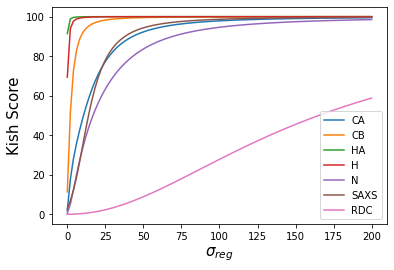

In [14]:
for key in KishScan:
 plt.plot(KishScan[key]['kish'][:,0],KishScan[key]['kish'][:,1],label='%s'%key)
plt.legend()
plt.xlabel(r'$\sigma_{reg}$',size=15)
plt.ylabel('Kish Score', size=15)
plt.savefig('%s/Kishscan.png'%outdir)
plt.show() 

In [15]:
theta_0_new = {'HA': 1.0,
 'CA': 4.04,
 'CB': 2.02,
 'C': 1.0,
 'H': 1.0,
 'HA2': 1.0,
 'HA3': 1.0,
 'N': 6.06,
 'RDC': 80.80,
 'Rg': 1.0,
 'JHNHA': 1.0,
 'SAXS': 8.08}

In [16]:
def func_new(l, traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md ):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    f += 0.5*np.sum((sigma_reg*sigma_reg)*l**2+sigma_md*sigma_md*l**2)
    der += sigma_reg*sigma_reg*l+sigma_md*sigma_md*l
    #der += (sigma)*l
    return(f,der)

In [17]:
reweighting_keys = [['CA','CB','N','H', 'SAXS','RDC']]
print('Reweighting keys: {}'.format(reweighting_keys))

To_Scan=reweighting_keys
#reweighting_keys = ['CA', 'CB','JHNHA']

#Thetas = ['1.00','2.00','5.00', '10.00', '20.00','40.00','60.00','100']

#thetas=[0,0.5,1,1.5,2,2.53,4,5,10,20,30]
thetas=np.linspace(0,3,50)
ref_theta=thetas[-1]

KishScan={}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan[CS]={}
    output_dir=join(save_path, CS)        
    print('Reweight Data = {}'.format(CS))
    RMSE_dict[CS]={}


    ### debugging variables
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure


    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_0_new, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0_new, sd,compare_dict_v)

    # THETA CYCLE
    theta_list=[]
    kish_list=[]
    rmsd_f_list=[]
    for theta_m in np.flip(thetas):
      
      s = '{:.2f}'.format(theta_m)
      print(s)
      #print(err_r)
      #print(sigma_md_r)
      sigma_reg=theta_m*err_r
      #print(sigma_reg)
      sigma_md=sigma_md_r
      RMSE_dict[CS][s]={}

      # iv) Print dimensions
      nobs_r = len(obs_exp_r)
      nobs_v = len(obs_exp_v)
      #Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

      # v) perform minimization
      # OBS: res.X = lagrange multiplier
      weight_bias=np.ones(nframes)
      if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


      if 'RDC' in Validation_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_v=np.dot(traj_v,initial_weights)
       exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_v_type['RDC']==1)
       traj_v[RDC_rows]=traj_v[RDC_rows]*c
      #sigma_md=np.ones(len(Sigma_dict_MDini[CS][:,3]))*err_d[CS]
      #print(CS,theta_m,sigma_md)
      res = sp.optimize.minimize(func_new, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
      initial_weights = Normalize_Weights(weight_bias)
      initial_obs_r=np.dot(traj_r,initial_weights)
      initial_obs_v=np.dot(traj_v,initial_weights)
      #if res.success: print("\nMinimization worked: {}\n".format(res.success))
      #else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
      final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      # e) final average observables for reweighting and validation
      final_obs_r=np.dot(traj_r,final_weights)
      final_obs_v=np.dot(traj_v,final_weights)
      # g) calculating Kish effective size
      Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
      Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
      #print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
      #print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
      Kish_ratio = (Ks_a/Ks_b)*100
      RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
      #print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
      theta_list.append(theta_m)
      kish_list.append(Kish_ratio)  
      rmsd_f_list.append(RMSE_reweight)
      RMSE_r_i={}
      RMSE_v_i={}
      RMSE_r_f={}
      RMSE_v_f={}
      RMSE_r_i['Tot']=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      for t in data_r_type:
       RMSE_r_i[t]=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_i['RDC_Q']=qf

      RMSE_v_i['Tot']=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
      for t in data_v_type:
       RMSE_v_i[t]=np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_i['RDC_Q']=qf
        
      RMSE_r_f['Tot']=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
      for t in data_r_type:
       RMSE_r_f[t]=np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_f['RDC_Q']=qf
      for t in data_v_type:
       RMSE_v_f[t]=np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_f['RDC_Q']=qf
      RMSE_dict[CS][s]['Kish']=Kish_ratio
      RMSE_dict[CS][s]['r_i']=RMSE_r_i
      RMSE_dict[CS][s]['r_f']=RMSE_r_f
      RMSE_dict[CS][s]['v_i']=RMSE_v_i
      RMSE_dict[CS][s]['v_f']=RMSE_v_f
    KishScan[CS]['kish']=np.column_stack((theta_list,kish_list))
    KishScan[CS]['rmsd']=np.column_stack((theta_list,rmsd_f_list))

Reweighting keys: [['CA', 'CB', 'N', 'H', 'SAXS', 'RDC']]
Reweight Data = CA-CB-N-H-SAXS-RDC
3.00
2.94
2.88
2.82
2.76
2.69
2.63
2.57
2.51
2.45
2.39
2.33
2.27
2.20
2.14
2.08
2.02
1.96
1.90
1.84
1.78
1.71
1.65
1.59
1.53
1.47
1.41
1.35
1.29
1.22
1.16
1.10
1.04
0.98
0.92
0.86
0.80
0.73
0.67
0.61
0.55
0.49
0.43
0.37
0.31
0.24
0.18
0.12
0.06
0.00


In [18]:
kish_mini = 20
Kish_ratio_vals = []
for key in KishScan:
    k = KishScan[key]['kish']
    b = (np.where(k[:,1] >= kish_mini))[0]
    idx = b[-1]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    print(key, theta_m)

CA-CB-N-H-SAXS-RDC 0.9183673469387755


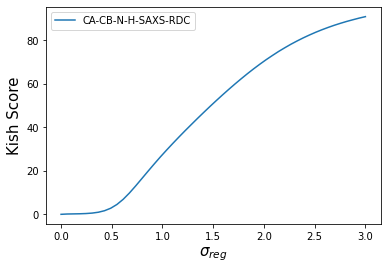

In [19]:
for key in KishScan:
 plt.plot(KishScan[key]['kish'][:,0],KishScan[key]['kish'][:,1],label='%s'%key)
plt.legend()
plt.xlabel(r'$\sigma_{reg}$',size=15)
plt.ylabel('Kish Score', size=15)
plt.savefig('%s/Kishscan.png'%outdir)
plt.show()

In [20]:
reweighting_keys = [['CA','CB', 'N','H', 'SAXS','RDC']]
To_Scan=reweighting_keys

CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_0_new, sd, compare_dict_r)
obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0_new, sd,compare_dict_v)


s = '{:.2f}'.format(theta_m)
# print(s)
# print(err_r)
# print(sigma_md_r)
sigma_reg=theta_m*err_r
# print(sigma_reg)
sigma_md=sigma_md_r
        

#s = '{:.2f}'.format(theta_m)
#sigma_md=sigma_md_r
nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


if 'RDC' in Validation_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_v=np.dot(traj_v,initial_weights)
       exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_v_type['RDC']==1)
       traj_v[RDC_rows]=traj_v[RDC_rows]*c


res = sp.optimize.minimize(func_new, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)

#Iniitial RMSE and Sigma 
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))

    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
      #print(" *    RDC scaled RMSD:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC scaled Q:", end = '')
      print(" %6.3lf" % qf)
    
print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    #(initial_obs_v-obs_exp_v)**2*data_v_type[t])
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
      #print(" *    RDC scaled RMSD:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC scaled Q:", end = '')
      print(" %6.3lf" % qf)
    
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdcs_scale_f,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
      #print(" *    RDC RMSE_scale:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_f,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
      #print(" *    RDC RMSE_scale:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)
np.savetxt('%s/weights_final.dat'%(outdir),final_weights,fmt=" %6.12lf")
# print final weights to file

f=open("%s/weights_final.a.dat"%outdir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

CA-CB-N-H-SAXS-RDC Theta: 0.9183673469387755 Kish: 23.143700 RMSD initail: 1.4371 RMSD final: 1.1796
Initial RMSE reweight data 
 * Total :      1.437
 *    CA :      0.756
 *    CB :      0.490
 *     N :      1.014
 *     H :      0.165
 *    SAXS :      0.746
 *    RDC :      3.278
 *    RDC scaled Q:  0.593
Initial RMSE validation data
 * Total :      0.410
 *    HA :      0.135
 *     C :      0.564
 *    Rg :      0.869
Final RMSE reweight data
 * Total :      1.180
 *    CA :      0.513
 *    CB :      0.401
 *     N :      0.702
 *     H :      0.098
 *    SAXS :      0.654
 *    RDC :      2.743
 *    RDC Q_scaled:  0.485
Final RMSE validation data
 * Total :      0.309
 *    HA :      0.120
 *     C :      0.415
 *    Rg :      0.816


In [21]:
err_d = { 'HA': 0.1,
          'CA': 0.2,
          'CB': 0.2,
          'C':  0.2,
          'H':  0.1,
          'HA2': 0.1,
          'HA3': 0.1,
          'N': 0.1 ,
          'RDC': 5.0 ,
          'Rg': 0.01,
          'SAXS': 0.03,
          'JHNHA': 0.25}

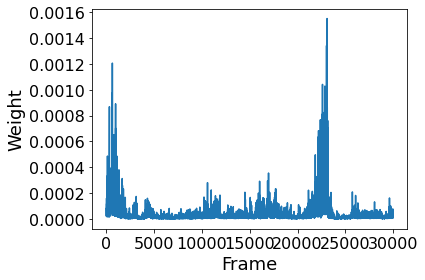

In [22]:
plt.plot(final_weights)
plt.ylabel('Weight',size=18)
plt.xlabel('Frame',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/FrameWeights.png'%outdir)
plt.show()

Rg Exp:  2.24+_  0.14 Rg Initial:  1.37 Rg Reweight:  1.42 


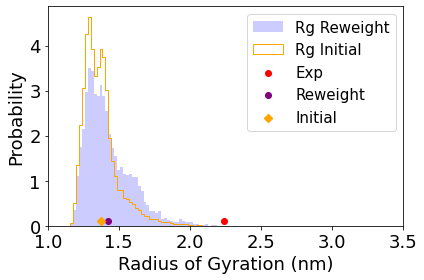

In [23]:
rg_i=np.dot(compare_dict_v['Rg'][0][1],initial_weights)
rg_r=np.dot(compare_dict_v['Rg'][0][1],final_weights)
rg_exp=expdata['Rg'][0][0]
rg_err=.14
print("Rg Exp:%6.2lf+_%6.2lf"%(rg_exp,rg_err),"Rg Initial:%6.2lf"%rg_i,"Rg Reweight:%6.2lf "%rg_r)

plt.hist(compare_dict_v['Rg'][0][1],bins=50,weights=final_weights,density='true',alpha=0.2,label='Rg Reweight',color='blue')
plt.hist(compare_dict_v['Rg'][0][1],bins=50,density='true',color='orange',histtype='step',label='Rg Initial')

plt.scatter(rg_exp,0.1,color='red',label='Exp')
plt.scatter(rg_r,0.1,color='purple',label='Reweight')
plt.scatter(rg_i,0.1,color='orange',marker='D',label='Initial')
plt.ylabel('Probability',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Radius of Gyration (nm)',size=18)
plt.legend(loc='upper right',fontsize=15)
plt.xlim(1.0, 3.5)

plt.tight_layout()
plt.savefig('%s/Rg.reweight.png'%outdir)
plt.show()
plt.clf()
plt.close()

CA
RMSD_initial: 0.756 RMSD_final: 0.513


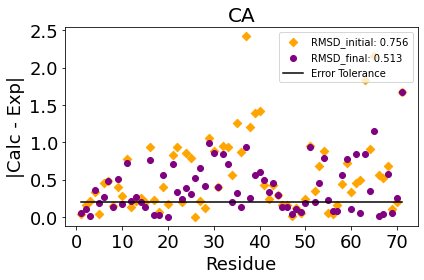

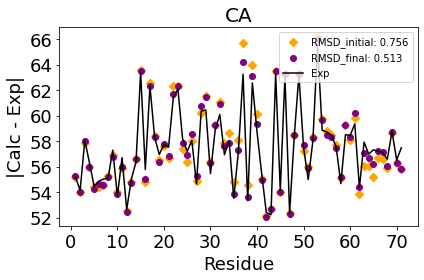

CB
RMSD_initial: 0.490 RMSD_final: 0.401


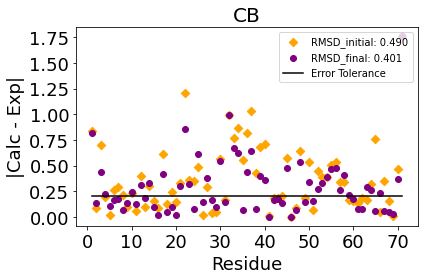

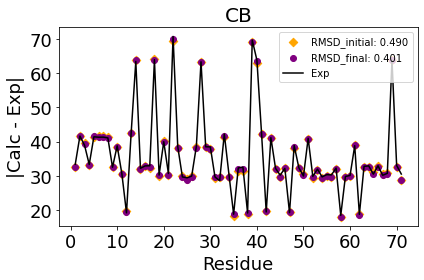

N
RMSD_initial: 1.014 RMSD_final: 0.702


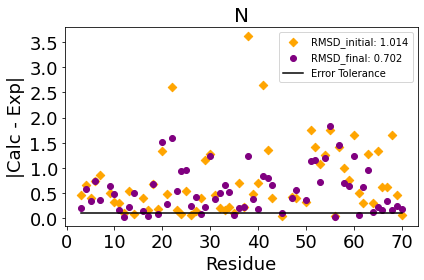

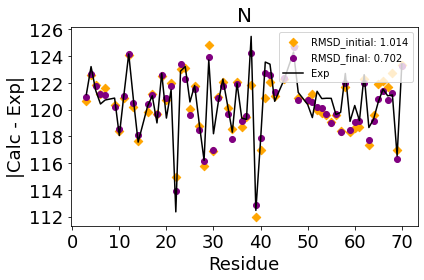

H
RMSD_initial: 0.165 RMSD_final: 0.098


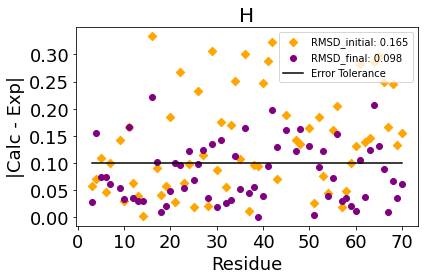

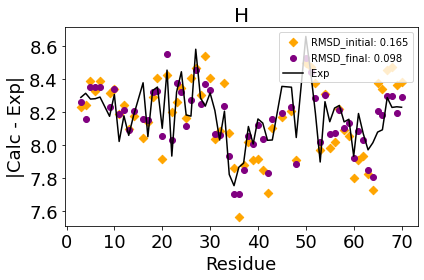

SAXS
RMSD_initial: 0.746 RMSD_final: 0.654


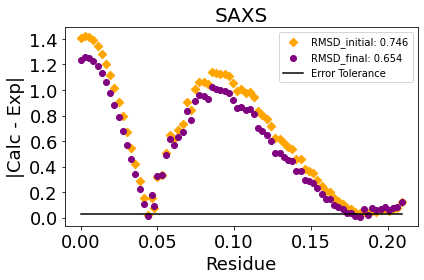

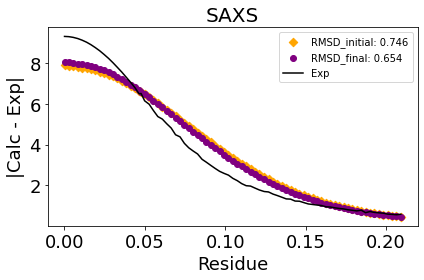

RDC
RMSD_initial: 3.278 RMSD_final: 2.743
RMSD initial scale: 3.278 RMSD final scale: 2.680
Q initial scale: 0.593 Q final scale: 0.485


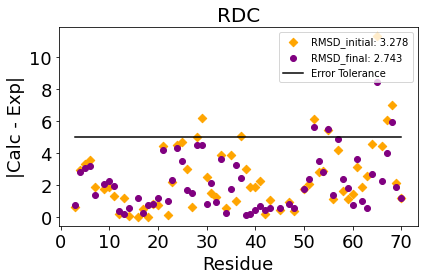

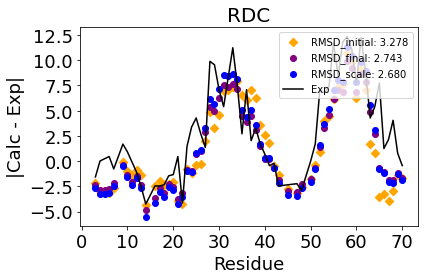

In [24]:
#Plot Fitting Data
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %rmsd_i,"RMSD_final:%6.3lf"%rmsd_f)
  plt.clf()
  if t=='RDC':
   qi_initial,rms_initial,qf_initial,rms_f_initial,rdc_scale_i_initial,c=scale_rdc_Q(exp,initial)
   qi_reweight,rms_i_reweight,qf_reweight,rms_f_reweight,rdc_scale_i_reweight,c=scale_rdc_Q(exp,reweight)
   print("RMSD initial scale:%6.3lf" %rms_f_initial,"RMSD final scale:%6.3lf"%rms_f_reweight)
   print("Q initial scale:%6.3lf" %qf_initial,"Q final scale:%6.3lf"%qf_reweight)
  plt.scatter(np.asarray(resid),np.absolute(initial-exp),color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
  plt.scatter(np.asarray(resid),np.absolute(reweight-exp),color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
  plt.plot(np.asarray(resid),err_fit,color='black',label='Error Tolerance')
  #max_dev=max(np.absolute(initial-exp))
  #plt.ylim(0,max_dev*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout()  
  plt.savefig('%s/%s.reweight.dev.png'%(outdir,t))
  plt.show()
  plt.clf()
  plt.scatter(np.asarray(resid),initial,color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
  plt.scatter(np.asarray(resid),reweight,color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
  if t=='RDC':
   plt.scatter(np.asarray(resid),rdc_scale_i_reweight,color='blue',label="RMSD_scale:%6.3lf"%rms_f_reweight)
  plt.plot(np.asarray(resid),exp,color='black',label='Exp')
  #max_dev=max(np.absolute(initial-exp))
  #plt.ylim(0,max_dev*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  plt.savefig('%s/%s.reweight.png'%(outdir,t))
  plt.show()

CA
RMSD_initial: 0.756 RMSD_final: 0.513


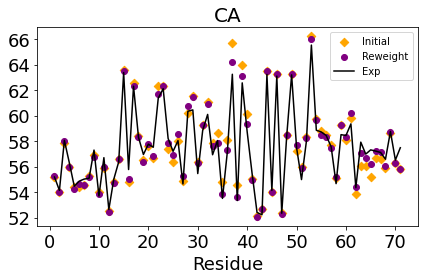

CB
RMSD_initial: 0.490 RMSD_final: 0.401


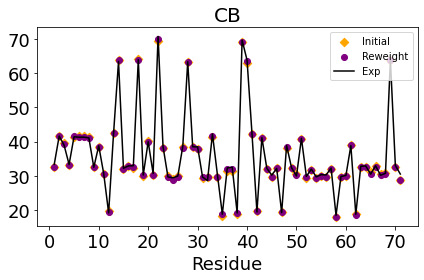

N
RMSD_initial: 1.014 RMSD_final: 0.702


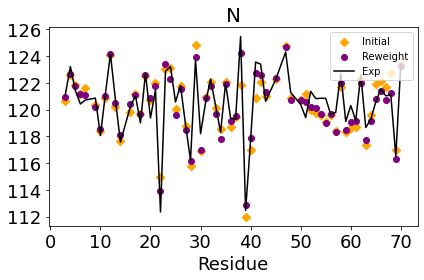

H
RMSD_initial: 0.165 RMSD_final: 0.098


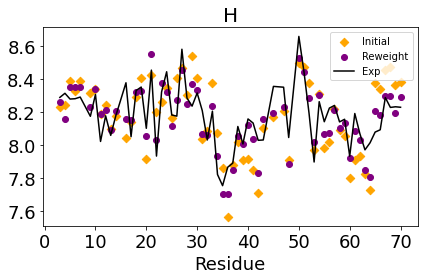

SAXS
RMSD_initial: 0.746 RMSD_final: 0.654


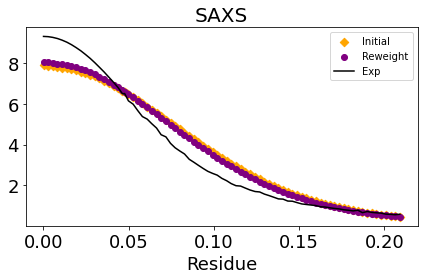

RDC
RMSD_initial: 3.278 RMSD_final: 2.743
Q_inital: 0.5930116066179786 RMS_initial: 3.278235826847815 Q_reweight: 0.4848215467467222 RMS_reweight: 2.680148830875669


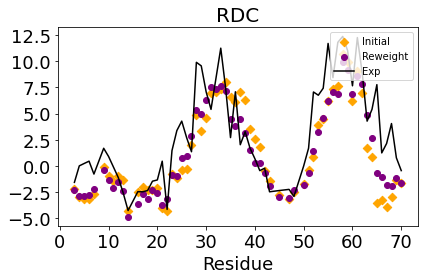

In [25]:
#Plot Fitting Data
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
  if t=='RDC':
   qi_i,rms_i_i,qf_i,rms_f_i,i_fit,c=scale_rdc_Q(exp,initial)   
   qi_f,rms_f_f,qf_f,rms_f_f,f_fit,c=scale_rdc_Q(exp,reweight)   
   print("Q_inital:",qf_i,"RMS_initial:",rms_f_i,"Q_reweight:",qf_f,"RMS_reweight:",rms_f_f) 
  plt.clf()
  plt.scatter(np.asarray(resid),initial,color='orange',marker='D',label="Initial")   
  plt.scatter(np.asarray(resid),reweight,color='purple',label="Reweight")
  plt.plot(np.asarray(resid),exp,color='black',label='Exp')

  #max=max(np.absolute(exp))
  #plt.ylim(0,max*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  #plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  plt.savefig('%s/%s.reweight.compare.png'%(outdir,t))
  plt.show()

HA
RMSD_initial: 0.135 RMSD_final: 0.120


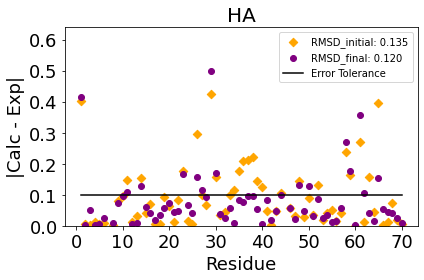

C
RMSD_initial: 0.564 RMSD_final: 0.415


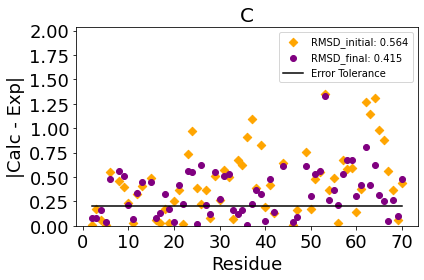

In [26]:
#Plot Validation Data
for t in Validation_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_v[t]): 
   resid.append(float(id))
   exp.append(compare_dict_v[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_v*data_v_type[t])
  reweight=np.trim_zeros(final_obs_v*data_v_type[t])
  exp=np.trim_zeros(obs_exp_v*data_v_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
  if t=='RDC':
   qi_i,rms_i_i,qf_i,rms_f_i,i_fit=scale_rdc_Q(exp,initial)   
   qi_f,rms_f_f,qf_f,rms_f_f,f_fit=scale_rdc_Q(exp,reweight)   
   print("Q_inital:",qf_i,"RMS_initial:",rms_f_i,"Q_reweight:",qf_f,"RMS_reweight:",rms_f_f)  
  plt.clf()
  plt.scatter(np.asarray(resid),np.absolute(initial-exp),color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
  plt.scatter(np.asarray(resid),np.absolute(reweight-exp),color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
  plt.plot(np.asarray(resid),err_fit,color='black',label='Error Tolerance')
  max_dev=max(np.absolute(initial-exp))
  plt.ylim(0,max_dev*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  plt.savefig('%s/%s.reweight.dev.val.png'%(outdir,t))
  plt.show()